In [1]:
# following https://www.kaggle.com/nageshsingh/build-knowledge-graph-using-python 
# as a starting point. 
import re
import spacy
import numpy as np 
import pandas as pd 
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from tqdm import tqdm

import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

# load the spacy model
nlp = spacy.load('en_core_web_sm')


Quick disclaimer. For this demonstration, I will be using the nhEvents dataset for constructing the knowledge graph. The choice is based on how this information is already condensed to a single sentence, with no html cleanup. 


This notebook contains the process used to extract subject-relation-object triples from the nhEvent captions from the NASA EO dataset. At the bottom we observe what some of the most common relations point to, as well as provide an html file on how to view the entire network. 

Obvious places for improvement are using the full NASA EO dataset rather than the sentences from just nhEvent captions, as well as introducing more quantitative analysis which I currently do not have the background on KG's to produce. 

Even so, I do feel like the work here does show promise, as we can learn from the produced knowledge graphs that heavy rain triggers flooding. 

In [2]:
# load the json file
import json
with open('data/nhEvents.json') as f:
    data = json.load(f) 
nhEvents = pd.DataFrame(data)

In [3]:
# remove captions which are too small to be useful. 
nhEvents = nhEvents[nhEvents['caption'].str.len() > 5]

We are modeling this knowledge graph with triples. These are sets of three items such as subject, verb, and object. Using the Spacy model to extract these grammatical properties, we can see below what decomposed sentence contains. 

In [4]:
nhEvents['caption'].values[4]

'Rising global temperatures and long-term rain and snow deficits have parched many states.'

In [5]:
doc = nlp(nhEvents['caption'].values[4])

for tok in doc:
    print(tok.text, "...", tok.dep_)

Rising ... amod
global ... amod
temperatures ... nsubj
and ... cc
long ... amod
- ... punct
term ... nmod
rain ... nmod
and ... cc
snow ... conj
deficits ... conj
have ... aux
parched ... ROOT
many ... amod
states ... dobj
. ... punct


As we can see, not all of these words are relevent. What we have to do next is extract all relevant entities with their proper prefixes and modifiers from these tokens. 

In [6]:
def get_entities(text):
    """
    Returns the subject and object entities of the text input sentence.
    """
    ent1 = ""
    ent2  = ""
    prefix = ""
    modifier = ""
    prv_tok_dep = ""
    prv_tok_text = ""
    for tok in nlp(text):
        if tok.dep_ != "punct":
            # check if the token is a compound word
            if tok.dep_ == "compound":
                prefix = tok.text
                if prv_tok_dep == "compound":
                    # if the previous token was a compound word, 
                    # then we need to add the prefix to the previous token
                    prefix = prv_tok_text + " " + prefix
            
            # check if token is a modifier
            if tok.dep_.endswith("mod"):
                modifier = tok.text
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + modifier
    
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                # reset the pref and modifier for object. 
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text
                prv_tok_dep = tok.dep_
                prv_tok_text = tok.text
    return [ent1.strip(), ent2.strip()]
    

In [7]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add('matching_pattern', patterns=[pattern])
    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [8]:
get_relation(nhEvents['caption'].values[1218])

'ignited'

In [9]:
relations = [get_relation(i) for i in tqdm(nhEvents['caption'].values)]

100%|██████████| 3904/3904 [00:21<00:00, 185.83it/s]


In [10]:


entity_pairs = []

for i in tqdm(nhEvents["caption"].values):
    entity_pairs.append(get_entities(i))



100%|██████████| 3904/3904 [00:19<00:00, 197.30it/s]


Now that we have our rough predictions for entity and relations, let's build the knowledge graph!

In [12]:
# extract subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df['category'] = nhEvents['category'] # add category from the original dataset 
kg_df.to_excel('data/nhEvent_kg_df.xlsx',index=False)

In [13]:
kg_df.sample(n=5)

,source,target,edge,category
2367,,likely Mediterranean February,storm,[Dust and Haze]
3749,Storm Edouard,southeast Atlantic September,creates,[Floods]
3725,Active York fires,landscape,dot,[Fires]
3367,Heavy winds,considerable northern Dec.,kicked,[Dust and Haze]
12,seasonal winds,interior drylands,loft,[Dust and Haze]


Much of this is noise. I am curious how much value a domain specific entity extraction model might bring. 

In [14]:


# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())



To view this knowledge graph, I am going to create a PyVis network visualization

In [17]:
from pyvis.network import Network
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
for row in kg_df.iterrows():
    break
    net.add_node(row[1]['source'], label=row[1]['source'])
    net.add_node(row[1]['target'], label=row[1]['target'])
    net.add_edge(row[1]['source'], row[1]['target'], label=row[1]['edge'])

net.show('nhEvent_knowledge_graph.html')

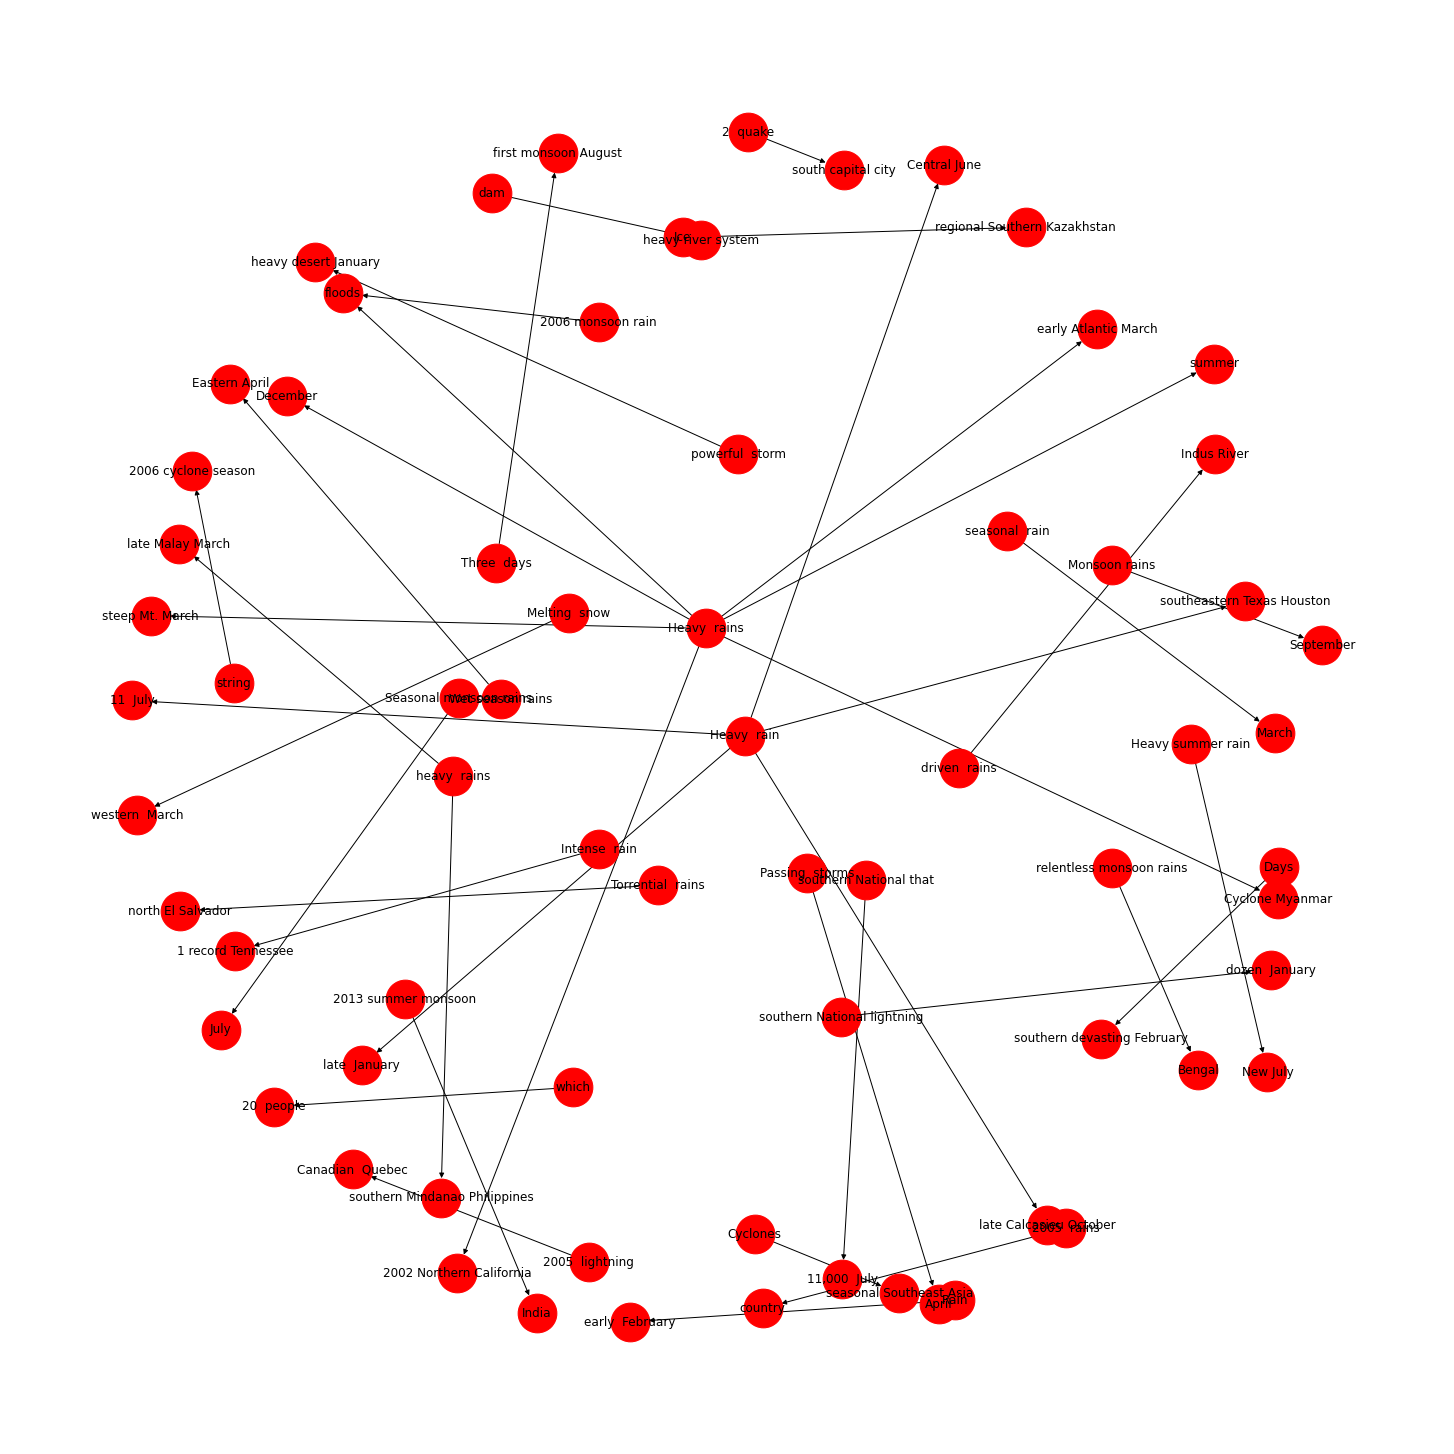

In [18]:
# create a directed-graph from the dataframe on the most popular relations
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="triggered"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


I want to take a minute to think about what this is saying. Rain triggers floods. We can "learn" this from the concepts extracted here! There is so much more to learn, but here is a quick demo on what knowledge can be obtained from NASA EO!

I see thee primary patterns here. Event location triples, event time triples, and event event triples. With further digging into the kinds of entities Spacy extracts, I imagine such triples can be separately viewed. 

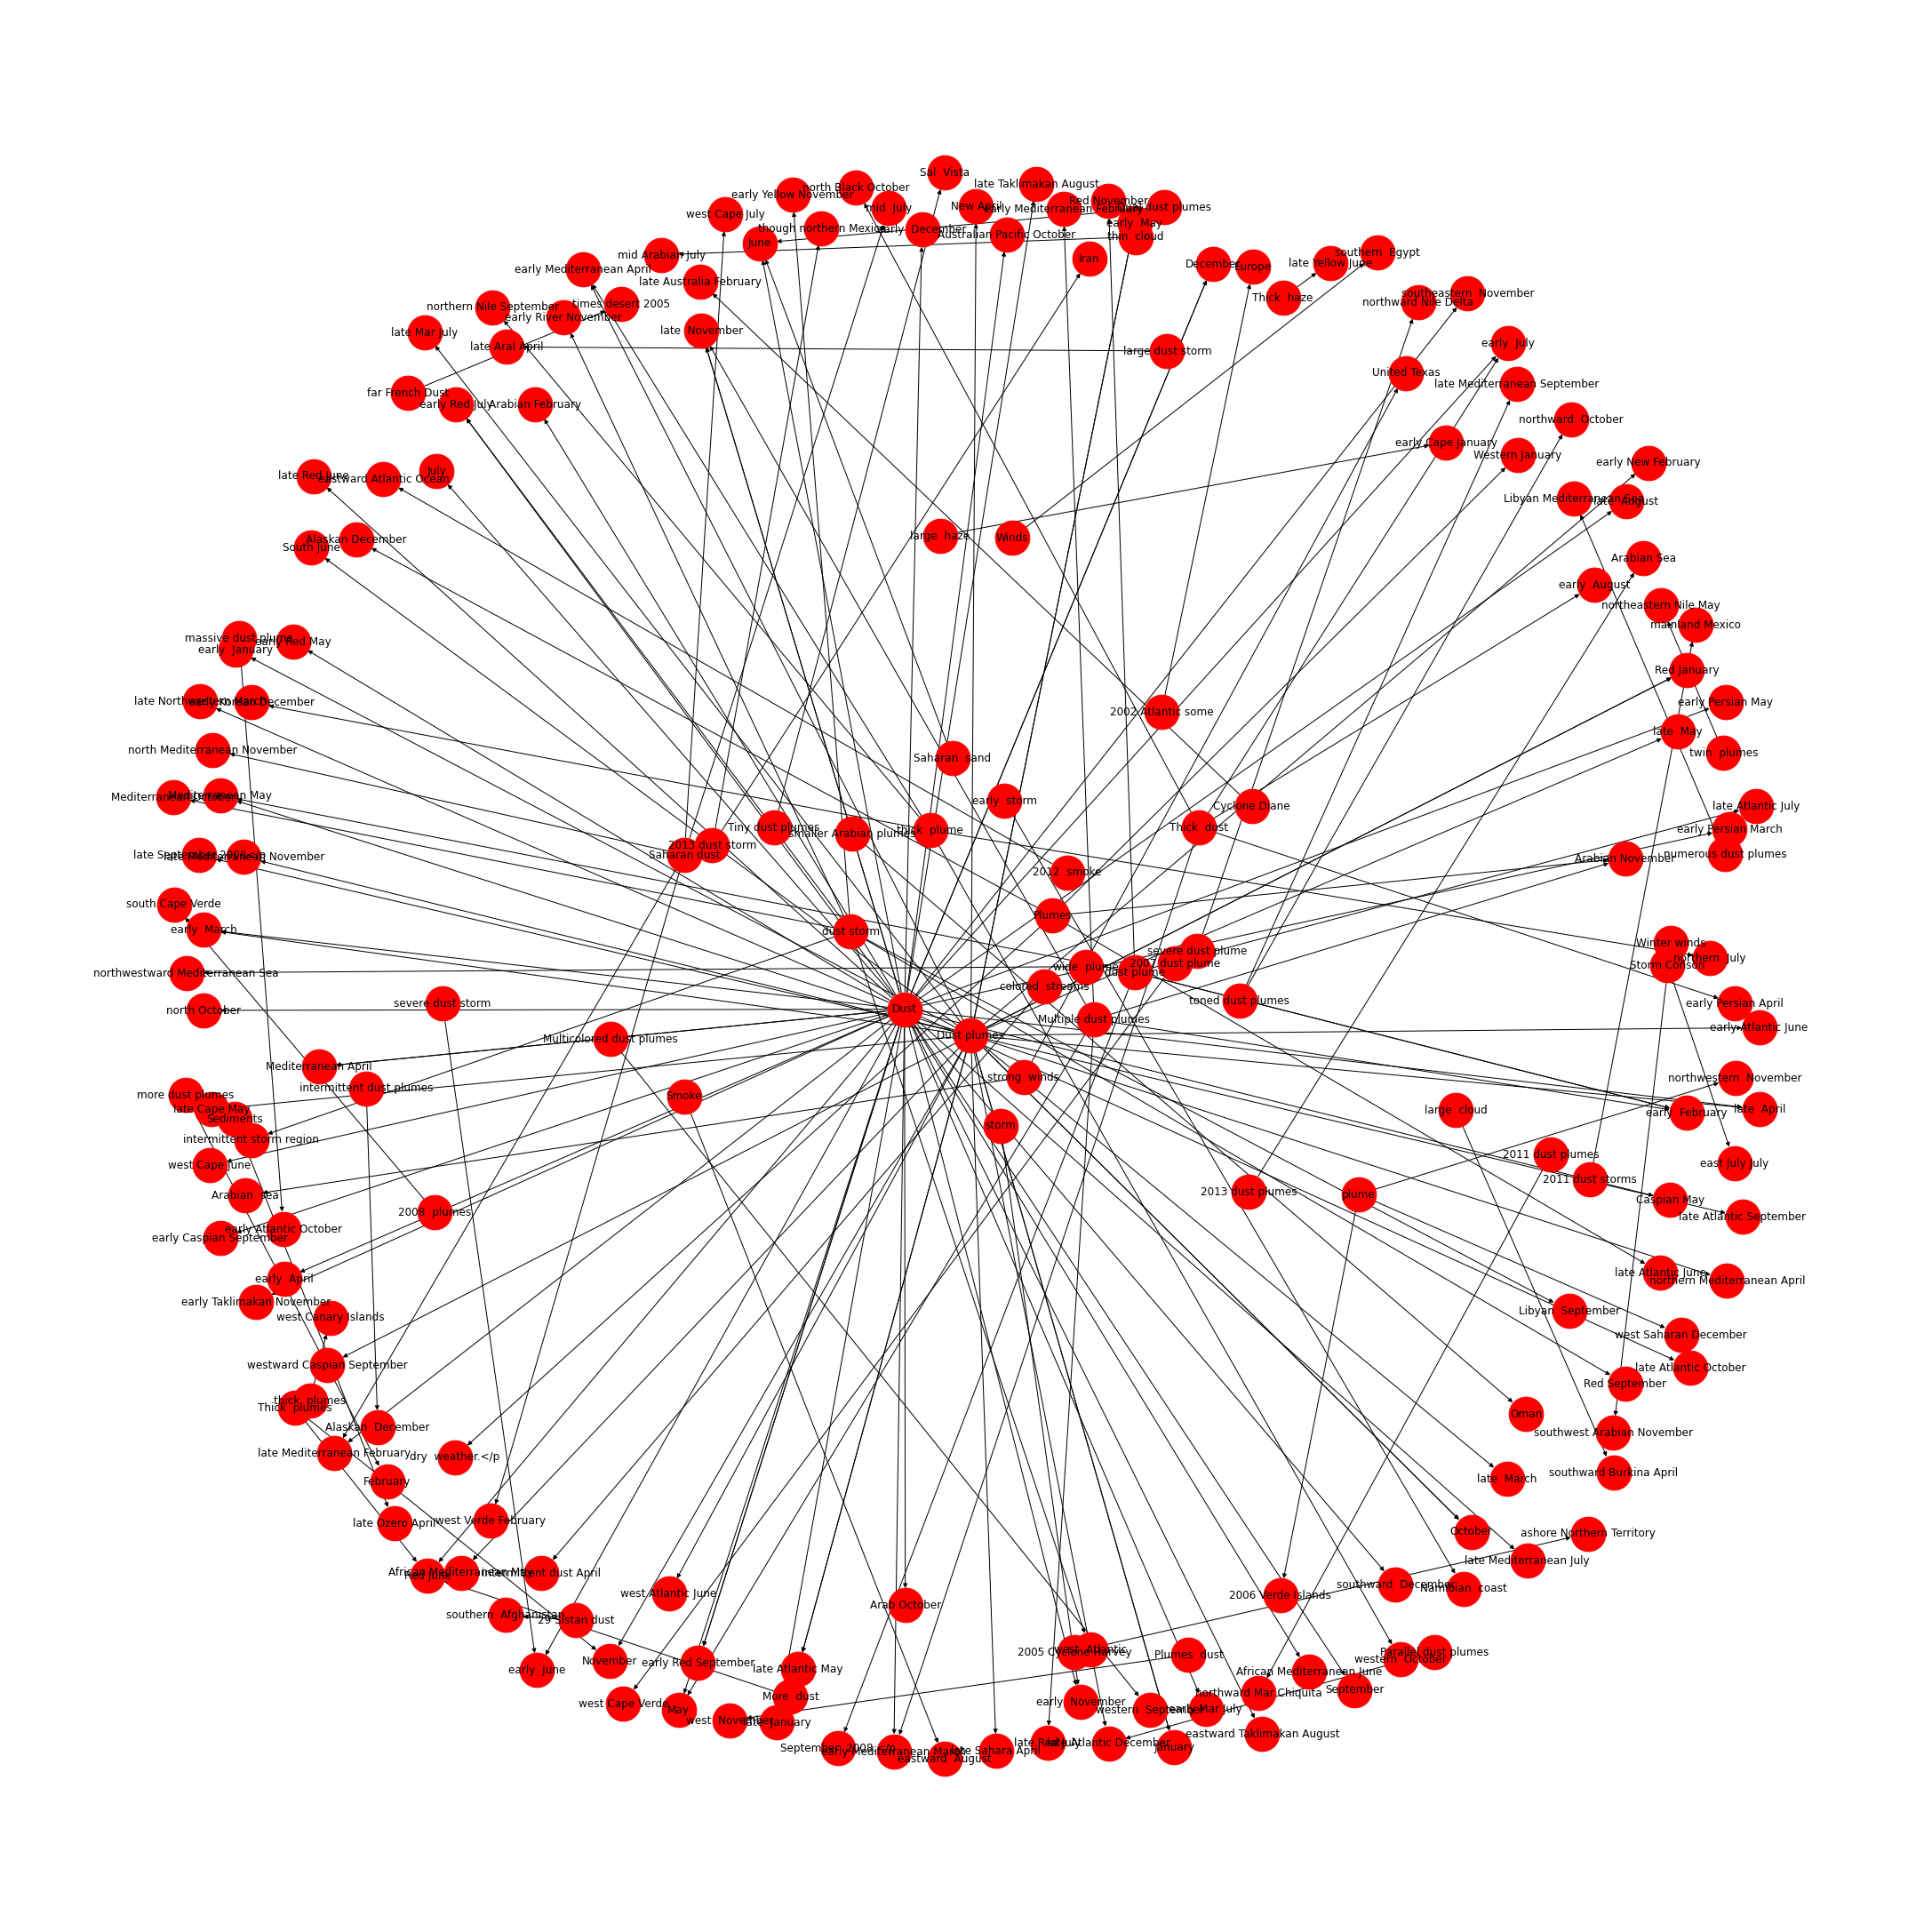

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="blew"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(30,30))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()
